In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
from heapq import heappush, heappop
import random

In [2]:
class PrimLabels:
    def __init__(self, graph):
        # Сохраняем матрицу смежности графа
        self.graph = graph
        # Запоминаем количество вершин в графе (размер матрицы)
        self.V = len(graph)
        
    def find_mst(self):
        # Создаем массив для отметки вершин, которые уже включены в MST
        # False - вершина не в MST, True - вершина в MST
        selected = [False] * self.V
        
        # Список для хранения ребер минимального остовного дерева
        # Каждое ребро будет храниться как кортеж (откуда, куда)
        mst_edges = []
        
        # Переменная для подсчета общего веса MST
        total_weight = 0
        
        # Проверяем связность графа перед построением MST
        # Если граф не связный, MST построить невозможно
        if not self.is_connected():
            return [], 0
            
        # Начинаем с вершины 0 - помечаем её как выбранную
        selected[0] = True
        
        # Основной цикл алгоритма
        # Выполняется V-1 раз, так как в MST должно быть V-1 ребер
        for _ in range(self.V - 1):
            # Инициализируем переменные для поиска минимального ребра
            minimum = float('inf')  # Минимальный вес текущего ребра (начальное значение - бесконечность)
            min_edge = None        # Ребро с минимальным весом (пока не найдено)
            
            # Перебираем все вершины графа
            for i in range(self.V):
                # Если вершина i уже в MST
                if selected[i]:
                    # Ищем ребра из вершины i во все остальные вершины
                    for j in range(self.V):
                        # Проверяем условия:
                        # 1. Вершина j еще не в MST (not selected[j])
                        # 2. Существует ребро между i и j (self.graph[i][j] > 0)
                        if not selected[j] and self.graph[i][j] > 0:
                            # Если нашли ребро с весом меньше текущего минимума
                            if self.graph[i][j] < minimum:
                                # Обновляем минимальный вес
                                minimum = self.graph[i][j]
                                # Запоминаем это ребро
                                min_edge = (i, j)
            
            # Если не нашли подходящего ребра, значит граф несвязный
            if min_edge is None:
                return [], 0
                
            # Добавляем найденную вершину в MST
            selected[min_edge[1]] = True
            # Добавляем найденное ребро в список рёбер MST
            mst_edges.append(min_edge)
            # Увеличиваем общий вес MST на вес добавленного ребра
            total_weight += minimum
                
        # Возвращаем построенное MST (список ребер) и его общий вес
        return mst_edges, total_weight
        
    def is_connected(self):
        # Массив для отметки посещенных вершин при поиске в глубину
        visited = [False] * self.V
        
        # Вложенная функция для реализации поиска в глубину (DFS)
        def dfs(v):
            # Отмечаем текущую вершину как посещенную
            visited[v] = True
            # Перебираем все возможные вершины
            for i in range(self.V):
                # Если есть ребро в вершину i и она еще не посещена
                if self.graph[v][i] > 0 and not visited[i]:
                    # Рекурсивно запускаем поиск из вершины i
                    dfs(i)
        
        # Запускаем поиск в глубину из вершины 0
        dfs(0)
        # Проверяем, что все вершины были достигнуты
        # Если все True - граф связный, иначе - несвязный
        return all(visited)

Этот алгоритм работает по принципу "жадного" выбора - на каждом шаге выбирается ребро с минимальным весом, 
соединяющее уже построенную часть MST с остальным графом. Такой подход гарантированно приводит к построению 
минимального остовного дерева, если граф связный. Сложность алгоритма O(V²) обусловлена тем, что на каждом 
шаге мы просматриваем все возможные ребра между выбранными и невыбранными вершинами. Это делает алгоритм 
менее эффективным на больших графах по сравнению с реализацией на куче, но более простым для понимания и реализации.

In [3]:
class PrimHeap:
    def __init__(self, graph):
        # Матрица смежности графа и кол-во вершин
        self.graph = graph
        self.V = len(graph)
        
    def is_connected(self):
        # Создаем массив для отметки посещенных вершин
        visited = [False] * self.V
        
        # Вспомогательная функция для поиска в глубину
        def dfs(v):
            visited[v] = True
            # Проходим по всем вершинам
            for i in range(self.V):
                # Если есть ребро и вершина не посещена
                if self.graph[v][i] > 0 and not visited[i]:
                    dfs(i)
        
        # Запускаем поиск из вершины 0            
        dfs(0)
        # Проверяем, все ли вершины достижимы
        return all(visited)
        
    def find_mst(self):
        # Проверяем связность графа
        if not self.is_connected():
            return [], 0
            
        # Массив для отметки выбранных вершин
        selected = [False] * self.V
        # Список для хранения рёбер MST
        mst_edges = []
        # Суммарный вес MST
        total_weight = 0
        # Создаем пустую кучу
        heap = []
        
        # Начинаем с вершины 0
        selected[0] = True
        # Добавляем все рёбра из вершины 0 в кучу
        for j in range(self.V):
            if self.graph[0][j] > 0:
                # Добавляем кортеж (вес, откуда, куда)
                heappush(heap, (self.graph[0][j], 0, j))
        
        # Пока куча не пуста и не набрали V-1 рёбер
        while heap and len(mst_edges) < self.V - 1:
            # Извлекаем ребро с минимальным весом
            weight, u, v = heappop(heap)
            # Если вершина уже в MST, пропускаем
            if selected[v]:
                continue
                
            # Добавляем вершину в MST
            selected[v] = True
            # Добавляем ребро в список
            mst_edges.append((u, v))
            # Увеличиваем общий вес
            total_weight += weight
            
            # Добавляем все новые рёбра из добавленной вершины
            for j in range(self.V):
                if not selected[j] and self.graph[v][j] > 0:
                    heappush(heap, (self.graph[v][j], v, j))
        
        # Если не нашли V-1 рёбер, значит MST не существует
        if len(mst_edges) != self.V - 1:
            return [], 0
                    
        return mst_edges, total_weight

Этот алгоритм находит минимальное остовное дерево (MST) графа, используя бинарную кучу для эффективного выбора рёбер с минимальным весом. Куча автоматически поддерживает рёбра отсортированными по весу, что позволяет быстро получать ребро с минимальным весом на каждом шаге алгоритма.

In [4]:
def is_connected(self):
    # Создаем список для отслеживания посещенных вершин
    # Изначально все вершины не посещены (False)
    visited = [False] * self.V
    
    def dfs(v):
        # Помечаем текущую вершину как посещенную
        visited[v] = True
        
        # Перебираем все возможные вершины графа
        for i in range(self.V):
            # Проверяем условия:
            # 1. self.graph[v][i] > 0 - существует ребро между вершинами v и i
            # 2. not visited[i] - вершина i еще не была посещена
            if self.graph[v][i] > 0 and not visited[i]:
                # Рекурсивно запускаем поиск из вершины i
                dfs(i)
                
    # Начинаем обход с вершины 0
    dfs(0)
    
    # Проверяем, были ли посещены все вершины
    # all(visited) вернет:
    # - True, если все элементы True (граф связный)
    # - False, если есть хотя бы один False (граф несвязный)
    return all(visited)

In [5]:
def verify_mst(graph, mst_edges):
    # Проверяем случай пустого MST
    # Если список ребер пуст (для несвязного графа), возвращаем True
    if not mst_edges:  
        return True
    
    # Получаем количество вершин в графе    
    V = len(graph)
    
    # Проверяем правило: в MST должно быть ровно V-1 ребер
    # Если количество ребер не равно V-1, это не MST
    if len(mst_edges) != V - 1:
        return False
    
    # Создаем множество для отслеживания посещенных вершин
    visited = set()
    # Преобразуем список ребер MST в список кортежей (начало, конец)
    edges = [(u, v) for u, v in mst_edges]
    
    # Вложенная функция для поиска в глубину
    def dfs(vertex):
        # Добавляем текущую вершину в множество посещенных
        visited.add(vertex)
        # Проходим по всем ребрам MST
        for u, v in edges:
            # Если текущая вершина - начало ребра и конец не посещен
            if u == vertex and v not in visited:
                dfs(v)
            # Если текущая вершина - конец ребра и начало не посещено
            elif v == vertex and u not in visited:
                dfs(u)
    
    # Начинаем обход с первой вершины первого ребра
    dfs(mst_edges[0][0])
    
    # Проверяем, что все вершины были посещены
    # MST верно, если количество посещенных вершин равно общему количеству вершин
    return len(visited) == V

In [6]:
#Функция генерирует случайный неориентированный взвешенный граф.

def generate_random_graph(n, density=0.6):  
    # n - количество вершин в графе
    # density - вероятность появления ребра между вершинами (0.6 = 60%)
    
    # Создаем пустую матрицу смежности размером n x n, заполненную нулями
    graph = np.zeros((n, n))
    
    # Проходим по верхнему треугольнику матрицы
    for i in range(n):  # перебор строк
        for j in range(i+1, n):  # перебор столбцов после диагонали
            # Генерируем случайное число от 0 до 1
            # Если оно меньше density, создаем ребро
            if random.random() < density:
                # Генерируем случайный вес ребра от 1 до 10
                weight = random.randint(1, 10)
                # Заполняем симметричные элементы матрицы
                graph[i][j] = weight 
                graph[j][i] = weight 
    
    return graph

In [7]:
def visualize_graph_and_mst(graph, mst_edges, title):
    if not mst_edges:
        plt.figure(figsize=(10, 6))
        plt.title(f"{title}\nГраф несвязный - MST не существует")
        plt.axis('off')
        plt.show()
        return
        
    G = nx.Graph()
    
    for i in range(len(graph)):
        for j in range(i+1, len(graph)):
            if graph[i][j] > 0:
                G.add_edge(i, j, weight=graph[i][j])
    
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 6))
    
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    
    mst = nx.Graph()
    mst.add_edges_from(mst_edges)
    nx.draw_networkx_edges(mst, pos, edge_color='r', width=2)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    
    total_weight = sum(graph[u][v] for u, v in mst_edges)
    plt.title(f"{title}\nОбщий вес MST: {total_weight}")
    plt.axis('off')
    plt.show()
    

In [8]:
def compare_performance():
    sizes = range(10, 501, 50)
    times_labels = []
    times_heap = []
    
    for size in sizes:
        graph = generate_random_graph(size)
        
        # Алгоритм на метках
        prim_labels = PrimLabels(graph)
        start = time.time()
        mst_edges_labels, _ = prim_labels.find_mst()
        times_labels.append(time.time() - start)
        
        # Алгоритм на куче
        prim_heap = PrimHeap(graph)
        start = time.time()
        mst_edges_heap, _ = prim_heap.find_mst()
        times_heap.append(time.time() - start)
    
    plt.figure(figsize=(12, 5))
    
    # # График в обычном масштабе
    # plt.subplot(121)
    # plt.plot(sizes, times_labels, 'b-', label='Prim Labels')
    # plt.plot(sizes, times_heap, 'r-', label='Prim Heap')
    # plt.xlabel('Размер графа')
    # plt.ylabel('Время выполнения (сек)')
    # plt.title('Сравнение в линейном масштабе')
    # plt.legend()
    # plt.grid(True)
    
    # График в логарифмическом масштабе
    plt.subplot(122)
    plt.plot(sizes, times_labels, 'b-', label='Prim Labels')
    plt.plot(sizes, times_heap, 'r-', label='Prim Heap')
    plt.yscale('log')  # логарифмическая шкала по Y
    plt.xlabel('Размер графа')
    plt.ylabel('Время выполнения (сек)')
    plt.title('Сравнение в логарифмическом масштабе')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

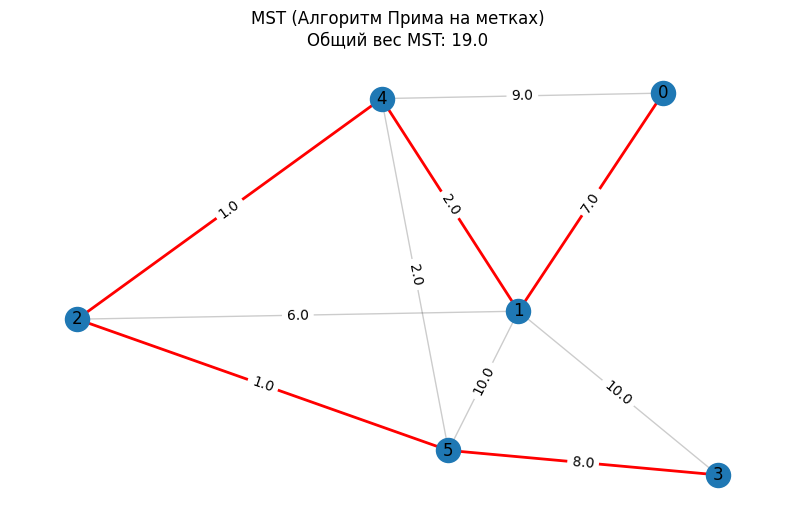

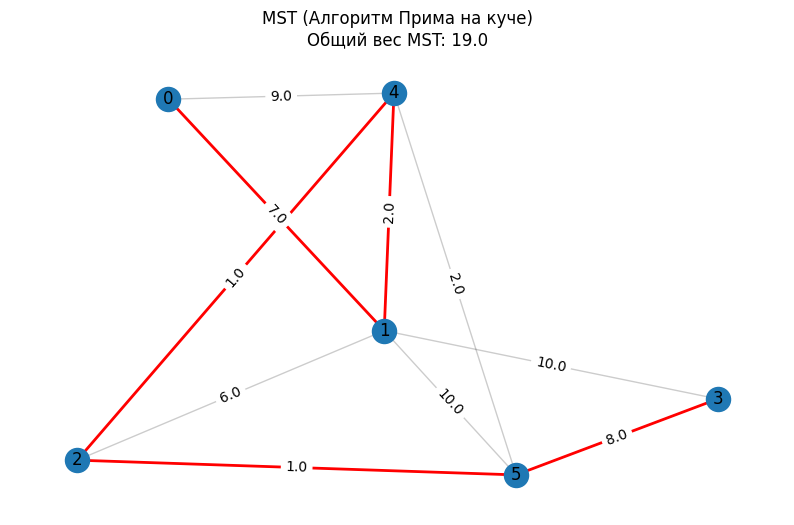

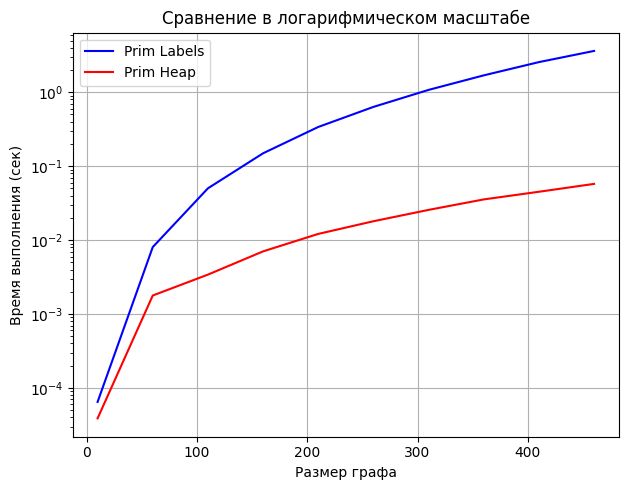

In [15]:
if __name__ == "__main__":
    # Создаем тестовый граф
    test_graph = generate_random_graph(6)
    
    # Находим MST обоими алгоритмами
    prim_labels = PrimLabels(test_graph)
    mst_edges_labels, weight_labels = prim_labels.find_mst()
    
    prim_heap = PrimHeap(test_graph)
    mst_edges_heap, weight_heap = prim_heap.find_mst()
    
    # Проверяем корректность
    if not verify_mst(test_graph, mst_edges_labels):
        print("Warning: Labels algorithm produced invalid MST")
    if not verify_mst(test_graph, mst_edges_heap):
        print("Warning: Heap algorithm produced invalid MST")
    
    # Визуализируем результаты
    visualize_graph_and_mst(test_graph, mst_edges_labels, "MST (Алгоритм Прима на метках)")
    visualize_graph_and_mst(test_graph, mst_edges_heap, "MST (Алгоритм Прима на куче)")
    
    # Сравниваем производительность
    compare_performance()

In [43]:
import numpy as np
from heapq import heappush, heappop

def prim_algorithm_labels(adjacency_matrix: np.array, vertex_neighbors: list) -> tuple:
    
    #Алгоритм Прима с использованием меток
    
    n = len(adjacency_matrix)
    visited = np.zeros(n, dtype=int)
    min_distances = np.full(n, np.inf)
    nearest_vertex = np.full(n, n)
    result_edges = []
    total_weight = 0
    
    visited[0] = 1
    for neighbor in vertex_neighbors[0]:
        min_distances[neighbor] = adjacency_matrix[0, neighbor]
        nearest_vertex[neighbor] = 0
        
    while len(result_edges) < n - 1:
        unvisited = np.where(visited == 0)[0]
        current = unvisited[min_distances[unvisited].argmin()]
        
        visited[current] = 1
        result_edges.append((nearest_vertex[current], current))
        total_weight += adjacency_matrix[nearest_vertex[current]][current]
        
        for neighbor in vertex_neighbors[current]:
            if not visited[neighbor]:
                new_distance = adjacency_matrix[current, neighbor]
                if new_distance < min_distances[neighbor]:
                    min_distances[neighbor] = new_distance
                    nearest_vertex[neighbor] = current
    
    return result_edges, total_weight

def prim_algorithm_heap(adjacency_matrix: np.array, vertex_neighbors: list) -> tuple:
    
    #Алгоритм Прима с использованием двоичной кучи
    
    n = len(adjacency_matrix)
    visited = np.zeros(n, dtype=int)
    result_edges = []
    total_weight = 0
    heap = []
    
    visited[0] = 1
    for neighbor in vertex_neighbors[0]:
        heappush(heap, (adjacency_matrix[0, neighbor], 0, neighbor))
    
    while heap and len(result_edges) < n - 1:
        weight, u, v = heappop(heap)
        
        if visited[v]:
            continue
            
        visited[v] = 1
        result_edges.append((u, v))
        total_weight += weight
        
        for neighbor in vertex_neighbors[v]:
            if not visited[neighbor]:
                heappush(heap, (adjacency_matrix[v, neighbor], v, neighbor))
    
    if len(result_edges) != n - 1:
        return [], 0
        
    return result_edges, total_weight

def test_predefined_graph():
    
    #1
    test_matrix = np.array([
        [0, 2, 4, 0, 8],
        [2, 0, 3, 5, 1],
        [4, 3, 0, 6, 0],
        [0, 5, 6, 0, 4],
        [8, 1, 0, 4, 0]
    ])

    test_neighbors = [
        [1, 2, 4],      # соседи вершины 0
        [0, 2, 3, 4],   # соседи вершины 1
        [0, 1, 3],      # соседи вершины 2
        [1, 2, 4],      # соседи вершины 3
        [0, 1, 3]       # соседи вершины 4
    ]

    #2
    test_matrix = np.array([
        [0, 1, 3],
        [1, 0, 2],
        [3, 2, 0]
    ])

    test_neighbors = [
        [1, 2],    # соседи вершины 0
        [0, 2],    # соседи вершины 1
        [0, 1]     # соседи вершины 2
    ]

    #3
    test_matrix = np.array([
        [0, 10, 20, 0],
        [10, 0, 15, 25],
        [20, 15, 0, 30],
        [0, 25, 30, 0]
    ])

    test_neighbors = [
        [1, 2],      # соседи вершины 0
        [0, 2, 3],   # соседи вершины 1
        [0, 1, 3],   # соседи вершины 2
        [1, 2]       # соседи вершины 3
    ]

    #4
    test_matrix = np.array([
        [0, 4, 0, 0, 0, 2],
        [4, 0, 6, 0, 0, 3],
        [0, 6, 0, 3, 0, 1],
        [0, 0, 3, 0, 2, 0],
        [0, 0, 0, 2, 0, 4],
        [2, 3, 1, 0, 4, 0]
    ])

    test_neighbors = [
        [1, 5],        # соседи вершины 0
        [0, 2, 5],     # соседи вершины 1
        [1, 3, 5],     # соседи вершины 2
        [2, 4],        # соседи вершины 3
        [3, 5],        # соседи вершины 4
        [0, 1, 2, 4]   # соседи вершины 5
    ]
    
   
    
    print("Тестовый граф:")
    print("Матрица смежности:")
    print(test_matrix)
    print("\nСписки соседей:")
    for i, neighbors in enumerate(test_neighbors):
        print(f"Вершина {i}: {neighbors}")
    

    print("\nРезультаты алгоритма Прима на метках:")
    labels_edges, labels_weight = prim_algorithm_labels(test_matrix, test_neighbors)
    if labels_edges:
        print("Рёбра в MST:")
        for edge in labels_edges:
            print(f"Ребро {edge[0]} -- {edge[1]}")
        print(f"Общий вес MST: {labels_weight}")
    else:
        print("Граф несвязный - MST не существует")
    
    
    print("\nРезультаты алгоритма Прима на куче:")
    heap_edges, heap_weight = prim_algorithm_heap(test_matrix, test_neighbors)
    if heap_edges:
        print("Рёбра в MST:")
        for edge in heap_edges:
            print(f"Ребро {edge[0]} -- {edge[1]}")
        print(f"Общий вес MST: {heap_weight}")
    else:
        print("Граф несвязный - MST не существует")

test_predefined_graph()

Тестовый граф:
Матрица смежности:
[[0 4 0 0 0 2]
 [4 0 6 0 0 3]
 [0 6 0 3 0 1]
 [0 0 3 0 2 0]
 [0 0 0 2 0 4]
 [2 3 1 0 4 0]]

Списки соседей:
Вершина 0: [1, 5]
Вершина 1: [0, 2, 5]
Вершина 2: [1, 3, 5]
Вершина 3: [2, 4]
Вершина 4: [3, 5]
Вершина 5: [0, 1, 2, 4]

Результаты алгоритма Прима на метках:
Рёбра в MST:
Ребро 0 -- 5
Ребро 5 -- 2
Ребро 5 -- 1
Ребро 2 -- 3
Ребро 3 -- 4
Общий вес MST: 11

Результаты алгоритма Прима на куче:
Рёбра в MST:
Ребро 0 -- 5
Ребро 5 -- 2
Ребро 2 -- 3
Ребро 3 -- 4
Ребро 5 -- 1
Общий вес MST: 11
